# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #3
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, Febrary 16th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Optimization via Descent

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x - 0.0005\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Part A
- Visually verify that for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized for the given data.
- Implement gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.
- Implement stochastic gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.

### Part B
- Compare the update time of the two implementations. Briefly explain whether your observations are what you expected.
- Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3`. Briefly explain whether your observations are what you expected.

## Problem 2: More Varieties of Descent

The following refers to the same problem set up in Problem 1.

### Part A
Compare the performance of stochastic gradient descent for the following learning rates: 1, 0.1, 0.001, 0.0001. Based on your observations, describe the effect of the choice of learning rate on the performance of the algorithm.

### Part B
Implement mini-batch gradient descent (for a three significantly different batch sizes). Compare the performance of mini-batch gradient descent for the following learning rates: 1, 0.1, 0.001, 0.0001. Based on your observations, compare the effect of learning rates on stochastic gradient descent and on mini-batch gradient descent.

In [357]:
import numpy as np
import pandas as pd
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats 

x, y = np.genfromtxt('HW3_data.csv', delimiter=',')

In [358]:
x_sum = x.sum()
y_sum = y.sum()
n = len(x)

L = lambda l1, l2, x, y: 0.000045 * l2**2 * y.sum() - 0.000098 * l1**2 * x.sum() + 0.003926 * x.sum() * l1 * np.exp(-0.1 * (l1**2 + l2**2))
print L(2.05384, 0, x, y)

-9.9341040253


In [359]:
print 8. / x.sum()
print 0.2/ y_sum
print 0.2/ x_sum

-0.00392583882549
4.5058875158e-05
-9.81459706374e-05


In [360]:
print 0.000045 * y_sum
print 0.000098 * x_sum
print 0.003926 * x_sum

0.199738674533
-0.1997025438
-8.00032843835


In [386]:
grad = lambda l1, l2, x, y: np.array([-0.000098 * 2 * l1 * x.sum() + 0.003926 *  x.sum() * np.exp(-0.1 * (l1**2 + l2**2)) - 0.003926 * 2 * 0.1 *  x.sum() * l1**2 * np.exp(-0.1 * (l1**2 + l2**2)), 2 * 0.000045 * l2 * y.sum() - 0.1 * 2* 0.003926 *  x.sum() * l1 * l2 * np.exp(-0.1 * (l1**2 + l2**2))])

def gradient_descent(x, y, theta_init, step=0.01, maxsteps=0, precision=0.001):
    costs = []
    m = y.size # number of data points
    theta = theta_init
    history = [] # to store all thetas
   
    counter = 0
    oldcost = 0

    currentcost = L(theta[0], theta[1], x, y)

    costs.append(currentcost)
    history.append(np.array([0, 0]))
    history.append(theta)
    
    counter+=1
    while np.linalg.norm(history[-1] - np.array([2.05384, 0])) > precision:
        oldcost=currentcost
        gradient = grad(theta[0], theta[1], x, y)
        theta = theta - step * gradient  # update
        history.append(theta)
        
        currentcost = L(theta[0], theta[1], x, y)
        costs.append(currentcost)
        counter+=1
        if maxsteps:
            if counter == maxsteps:
                break
        
    return history, costs, counter

Gradient Descent: 2.05, 0.00 970
-9.93410279162


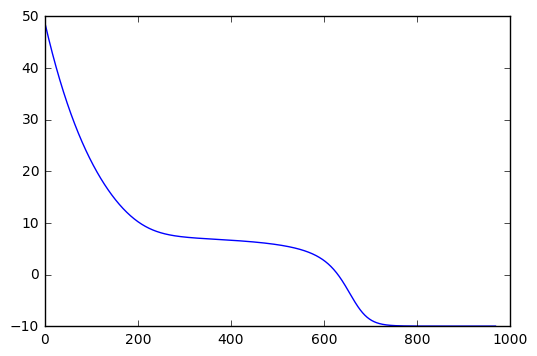

In [387]:
#theta_i = [-15, 40] + np.random.rand(2)
#theta_i = [-5, 2]
#theta_i = [15, 16]
theta_i = [-10, 12]
history, cost, iters = gradient_descent(x, y, theta_i, maxsteps=64001)
theta = history[-1]

print("Gradient Descent: {:.2f}, {:.2f} {:d}".format(theta[0], theta[1], iters))
print cost[-1]

plt.plot(range(len(cost)), cost);

In [392]:
grad = lambda l1, l2, x, y: np.array([-0.000098 * 2 * l1 * x.sum() + 0.003926 *  x.sum() * np.exp(-0.1 * (l1**2 + l2**2)) - 0.003926 * 2 * 0.1 *  x.sum() * l1**2 * np.exp(-0.1 * (l1**2 + l2**2)), 2 * 0.000045 * l2 * y.sum() - 0.1 * 2* 0.003926 *  x.sum() * l1 * l2 * np.exp(-0.1 * (l1**2 + l2**2))])

def sgd(x, y, theta_init, step=100, maxsteps=0, precision=0.000001):
    costs = []
    m = len(x) # number of data points
    oldtheta = []
    theta = theta_init
    history = [] # to store all thetas
    grads=[]
    counter = 0
    oldcost = 0
    epoch = 0
    i = 0 #index

    gradient = grad(theta[0], theta[1], x[i], y[i])
    
    grads.append(gradient)

    currentcost = L(theta[0], theta[1], x, y)
    
    counter+=1

    costsum = currentcost
    
    costs.append(currentcost)
    
    history.append(theta)
    print("start", counter, costs, oldcost)
    
    
    #while abs(currentcost - oldcost) > precision:
    while epoch < 4:
    #while np.linalg.norm(theta - oldtheta) > precision:
        #print("hi", precision)
        #oldcost=currentcost
        gradient = grad(theta[0], theta[1], x[i], y[i])
        grads.append(gradient)
        oldtheta = theta[:]
        #step = min(1/2. * np.linalg.norm(np.array(gradient)), 1)
        #print step
        theta = theta - step * gradient  # update
        #print gradient, theta, oldtheta
        history.append(theta)
        i += 1
        if i > m - 1:#reached one past the end.
            #break
            epoch +=1
            print epoch
            neworder = np.random.permutation(m)
            x = x[neworder]
            y = y[neworder]
            i = 0

        oldcost = currentcost
        currentcost =  L(theta[0], theta[1], x, y)
        costs.append(currentcost)

        if maxsteps:
            if counter == maxsteps:
                break
        
    
    return history, costs, grads, counter, epoch

('start', 1, [48.732623514742059], 0)
1
2
3
4
64001 47.1791590633
16.758558541


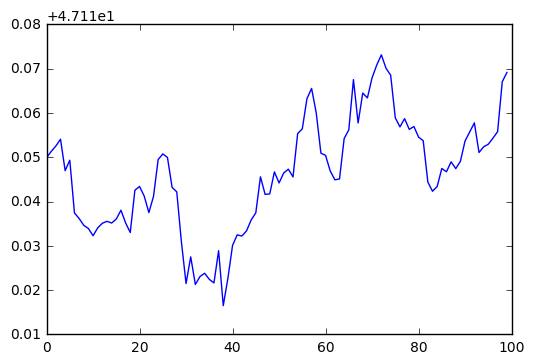

In [394]:
#[4, 2]
#theta_i = [1.5, 0.9] 
#theta_i = [4, 2]
theta_i = [-10, 12]
history, costs, grads, counter, epoch = sgd(x, y, theta_i, step=0.01, maxsteps=5000)
print len(costs), costs[-1]
print np.linalg.norm(history[-1] - np.array([2.05384, 0]))
plt.plot(range(len(costs[-100:])), costs[-100:])
#plt.ylim(-10, -9)